In [23]:
%%javascript
var kernel = IPython.notebook.kernel;
var body = document.body,  
    attribs = body.attributes;
var command = "__filename__ = " + "'" + decodeURIComponent(attribs['data-notebook-name'].value) + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [24]:
print(__filename__)

2D visualization of learning.ipynb


In [31]:
import os, sys, numpy as np, tensorflow as tf
from pathlib import Path

import time
try:
    print(__file__)
    __current_dir__ = str(Path(__file__).resolve().parents[0])
    __filename__ = os.path.basename(__file__)

except NameError:
    # jupyter notebook automatically sets the working 
    # directory to where the notebook is.
    __current_dir__ = str(Path(os.getcwd()))

module_parent_dir = str(Path(__current_dir__).resolve().parents[0])

sys.path.append(module_parent_dir)
import convnet_3_stage

__package__ = 'convnet_3_stage'
from . import network

from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

BATCH_SIZE = 250
SCRIPT_DIR = __current_dir__
FILENAME = __filename__
SUMMARIES_DIR = SCRIPT_DIR
SAVE_PATH = SCRIPT_DIR + "/network.ckpt"

### configure devices for this eval script.
USE_DEVICE = '/gpu:2'
session_config = tf.ConfigProto(log_device_placement=True)
session_config.gpu_options.allow_growth = True
# this is required if want to use GPU as device.
# see: https://github.com/tensorflow/tensorflow/issues/2292
session_config.allow_soft_placement = True

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [32]:
with tf.Graph().as_default() as g, tf.device(USE_DEVICE):
    # inference()
    input, deep_features = network.inference()
    labels, logits, loss_op = network.loss(deep_features)
    eval = network.evaluation(logits, labels)

    init = tf.initialize_all_variables()

    with tf.Session(config=session_config) as sess:
        
        saver = tf.train.Saver()

        saver.restore(sess, SAVE_PATH)

        # TEST_BATCH_SIZE = np.shape(mnist.test.labels)[0]
        logits_output, deep_features_output, loss_value, accuracy = \
            sess.run(
                [logits, deep_features, loss_op, eval], feed_dict={
                    input: mnist.test.images[5000:],
                    labels: mnist.test.labels[5000:]
                })
        print("MNIST Test accuracy is ", accuracy)

MNIST Test accuracy is  0.98


In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
color_palette = ['#507ba6', '#f08e39', '#e0595c', '#79b8b3', '#5ca153', 
                 '#edc854', '#af7ba2', '#fe9fa9', '#9c7561', '#bbb0ac']

In [35]:
from IPython.display import FileLink, FileLinks

/home/ubuntu/pynb/deep_learning_notes/Proj_Centroid_Loss_LeNet/convnet_3_stage/figures/MNIST LeNet++ with 2 Deep Features (PReLU).png

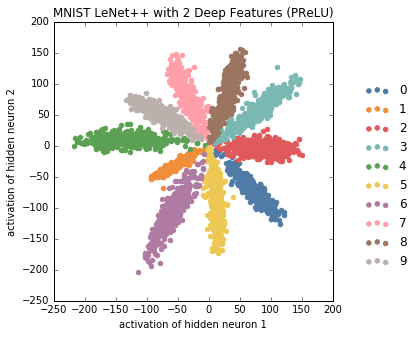

In [36]:
bins = {}
for logit, deep_feature in zip(logits_output, deep_features_output):
    label = np.argmax(logit)
    try:
        bins[str(label)].append(list(deep_feature))
    except KeyError:
        bins[str(label)] = [list(deep_feature)]

plt.figure(figsize=(5, 5))
for numeral in map(str, range(10)):
    try:
        features = np.array(bins[numeral])
    except KeyError:
        print(numeral + " does not exist")
        features = []
    plt.scatter(
        features[:, 0], 
        features[:, 1], 
        color=color_palette[int(numeral)],
        label=numeral
    )
    
plt.legend(loc=(1.1, 0.1), frameon=False)

title = 'MNIST LeNet++ with 2 Deep Features (PReLU)'
plt.title(title)
plt.xlabel('activation of hidden neuron 1')
plt.ylabel('activation of hidden neuron 2')

fname = './figures/' + title + '.png'
plt.savefig(fname, dpi=300, bbox_inches='tight')
FileLink(fname)